In [1]:
import pandas as pd
import numpy as np

# get data from ratings.csv
ratings_df = pd.read_csv('ratings.csv')
userId = ratings_df['userId'].values
movieId = ratings_df['movieId'].values
rating = ratings_df['rating'].values

# get the ratings matrix
ratings = np.zeros((np.amax(userId), np.amax(movieId)))
for i in range(len(rating)):
    ratings[userId[i]-1, movieId[i]-1] = rating[i]

ratings = ratings[:, ~np.all(ratings == 0, axis=0)]

#print(ratings)
#print(ratings.shape)

In [2]:
# Q1:
sparsity = 1 - np.count_nonzero(ratings) / np.size(ratings)
sparsity

0.9835608583913366

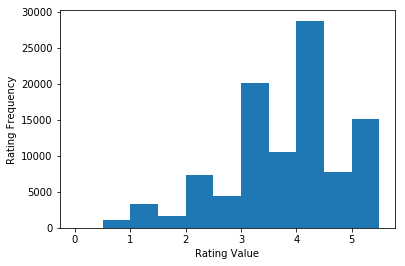

In [3]:
# Q2:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel('Rating Value')
plt.ylabel('Rating Frequency')
plt.hist(rating, bins=np.arange(0, 6, 0.5))
plt.show()

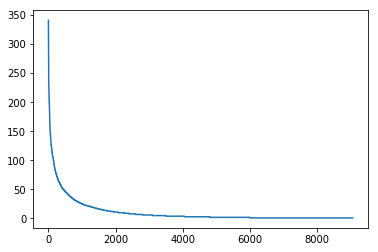

In [4]:
# Q3:
MDistr = np.count_nonzero(ratings,axis=0)
MDistr[::-1].sort()
plt.plot(MDistr)
plt.show()

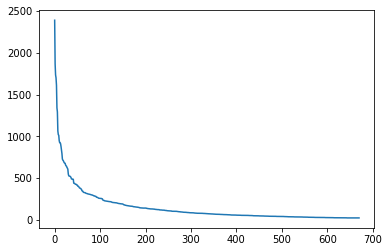

In [5]:
# Q4:
UDistr = np.count_nonzero(ratings,axis=1)
UDistr[::-1].sort()
plt.plot(UDistr)
plt.show()

** Q5: **
The salient feature of the distribution of ratings among movies is extremely unbalanced. To be more specific, some movies get more than three hundreds of ratings while others only get less than ten ratings. This makes the rating matrix sparse, and gives challenges to designing collaborative filtering methods since most of the ratings are unspecified. 

In order to solve the problem, we used the feature that the observed ratings are often highly correlated across various users and the similarity between users or items can be used to make inferences about incompletely specified values.

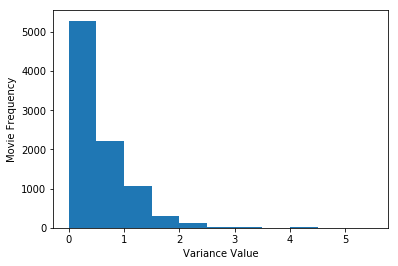

In [6]:
# Q6: 
# Compute the variance of the rating values received by each movie.
variance = np.zeros((ratings.shape[1],1))
i = 0
for col in ratings.T:
    variance[i] = np.var(col[col != 0])
    i += 1

plt.xlabel('Variance Value')
plt.ylabel('Movie Frequency')
plt.hist(variance, bins=np.arange(0, np.amax(variance)+0.5, 0.5))
plt.show()

**Q7: **
$\mu_u = \frac{1}{\vert I_u \vert} \sum_{k \in I_u} r_{uk}$ , where  $\vert I_u \vert$  is the cardinality of the set $I_u$. 

**Q8: **
$I_u \cap I_v $ is the set of items rated by both users `u` and `v`. $I_u \cap I_v = \emptyset$ when the users `u` and `v` don't have common items rated. 

** Q9: **
Mean-centering would better reflect the features. Given that each feature should have equal probabilty or weight to influence the classification result, a large scale of data, in our case moives rated by users who rate all items highly, would have a much greater weight than those rated by users who rate all items poorly and thus the features would not be a true representation of the data. 

Also, the proposed KNN algorithm is using Pearson-correlation coefficient as distance measure, in which the training ratings  would already have their mean substracted. It is quite obvious that the data to be predicted must be preprocessed the exact same way as the training data. 

In [7]:
# Q10:
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection.validation import cross_validate
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale = (0.5,5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

kgrid = np.arange(2,102,2)

In [8]:
RMSEs = np.zeros((50,1))
MAEs = np.zeros((50,1))
j = 0
for k in kgrid:
    knn = KNNWithMeans(k = k,sim_options = {'name': 'pearson'})
    cv_dict = cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    RMSEs[j] = np.mean(cv_dict['test_rmse'])
    MAEs[j] = np.mean(cv_dict['test_mae'])
    j += 1

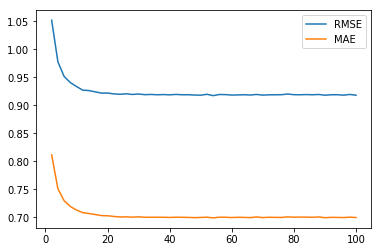

In [9]:
plt.plot(kgrid,RMSEs,label='RMSE')
plt.plot(kgrid,MAEs,label='MAE')
plt.legend()
plt.show()

In [10]:
# Q11:
for i in range(len(RMSEs)-1):
    if (RMSEs[i] - RMSEs[i+1]<0.001 and MAEs[i] - MAEs[i+1]<0.001):
        k = (i+1)*2
        RMSE = RMSEs[i]
        MAE = MAEs[i]
        break
print (k)
print (RMSE)
print (MAE)

18
[ 0.92193371]
[ 0.70333289]


In [11]:
def trimming(testset, OPT):
    """OPT: 0-Popular,1-Unpopular,2-High variance """
    TestMid = [testset[i][1] for i in range(len(testset))]
    uniMid,counts = np.unique(TestMid,return_counts = True)
    if OPT == 0:
        uniMid = uniMid[counts > 2]
    elif OPT == 1:
        uniMid = uniMid[counts <= 2]
    elif OPT == 2:
        uniMid = uniMid[counts >= 5]
        
    Testdata = []
    if OPT == 1 or OPT == 0:
        for i in range(len(testset)):
            if np.isin(testset[i][1],uniMid) == 1:
                Testdata.append(testset[i])
    elif OPT == 2:
        TestR = np.array([testset[i][2] for i in range(len(testset))])
        HVar = np.zeros(uniMid.shape)
        j = 0
        for Mid in uniMid:
            idx = TestMid == Mid
            HVar[j] = np.var(TestR[[idx]])
            j += 1
        uniMid = uniMid[HVar >= 2]
        for i in range(len(testset)):
            if np.isin(testset[i][1],uniMid) == 1:
                Testdata.append(testset[i])    
                
    return Testdata

In [12]:
# Q12:
from surprise.model_selection import KFold
from surprise import accuracy
kf = KFold(n_splits=10)

RMSE2d = np.zeros((50,10))

m = 0
for k in kgrid:
    n = 0
    print(m)
    knn = KNNWithMeans(k = k,sim_options = {'name': 'pearson'})
    for trainset, testset in kf.split(data):
        knn.fit(trainset)
        TestPop = trimming(testset, OPT = 0)
        predictions = knn.test(TestPop)
        RMSE2d[m,n] = accuracy.rmse(predictions, verbose=False)
        n += 1
    m += 1
    
RMSEs = np.mean(RMSE2d, axis=1)

0
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
1
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity mat

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
11
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matr

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
22
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matr

Done computing similarity matrix.
32
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
33
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity mat

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
43
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matr

The minimum average RMSE = 0.874067439229


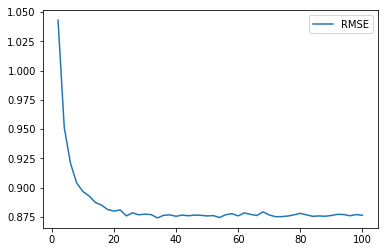

In [13]:
print('The minimum average RMSE = ' + str(np.amin(RMSEs)))
plt.plot(kgrid,RMSEs,label='RMSE')
plt.legend()
plt.show()

In [14]:
# Q13:
RMSE2d = np.zeros((50,10))

m = 0
for k in kgrid:
    n = 0
    print(m)
    knn = KNNWithMeans(k = k,sim_options = {'name': 'pearson'})
    for trainset, testset in kf.split(data):
        knn.fit(trainset)
        TestUnPop = trimming(testset, OPT = 1)
        predictions = knn.test(TestUnPop)
        RMSE2d[m,n] = accuracy.rmse(predictions, verbose=False)
        n += 1
    m += 1
    
RMSEs = np.mean(RMSE2d, axis=1)

0
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
1
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity mat

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
11
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matr

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
22
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matr

32
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
33
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity m

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
43
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matr

The minimum average RMSE = 1.00626582084


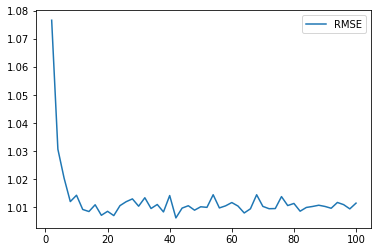

In [15]:
print('The minimum average RMSE = ' + str(np.amin(RMSEs)))
plt.plot(kgrid,RMSEs,label='RMSE')
plt.legend()
plt.show()

In [16]:
# Q14:
RMSE2d = np.zeros((50,10))

m = 0
for k in kgrid:
    n = 0
    print(m)
    knn = KNNWithMeans(k = k,sim_options = {'name': 'pearson'})
    for trainset, testset in kf.split(data):
        knn.fit(trainset)
        TestHighVar = trimming(testset, OPT = 2)
        predictions = knn.test(TestHighVar)
        RMSE2d[m,n] = accuracy.rmse(predictions, verbose=False)
        n += 1
    m += 1
    
RMSEs = np.mean(RMSE2d, axis=1)

0
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
1
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity mat

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
11
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
22
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matr

32
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
33
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity m

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
43
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matr

The minimum average RMSE = 1.38728168704


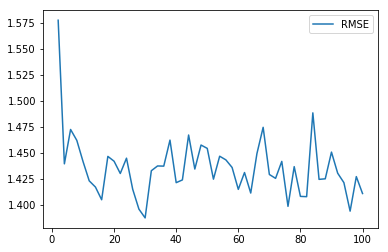

In [17]:
print('The minimum average RMSE = ' + str(np.amin(RMSEs)))
plt.plot(kgrid,RMSEs,label='RMSE')
plt.legend()
plt.show()

In [18]:
# Q15:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)
    plt.show()


In [19]:
from surprise.model_selection.split import train_test_split

data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

knn = KNNWithMeans(k = 18,sim_options = {'name': 'pearson'})
knn.fit(data_train)
predictions = knn.test(data_test)
predR = []
realR = []
for pred in predictions:
    predR.append(pred.est)
    realR.append(pred.r_ui)

Computing the pearson similarity matrix...
Done computing similarity matrix.


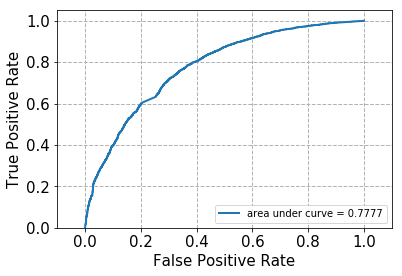

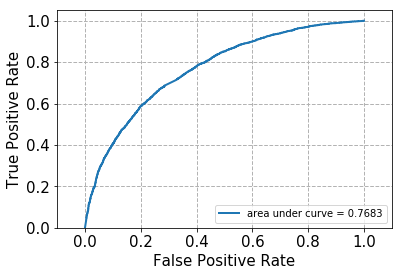

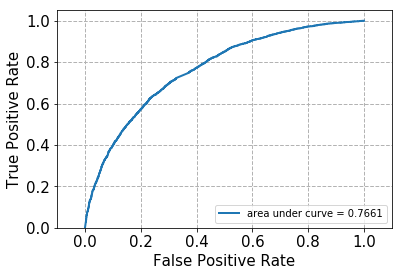

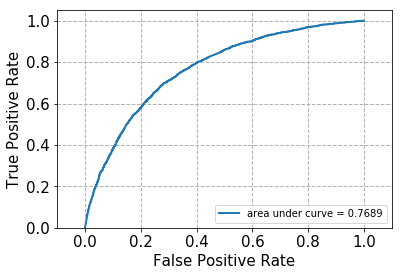

In [20]:
threshold = [2.5, 3, 3.5, 4]

for thres in threshold:
    predR_binary = []
    realR_binary = []
    for i in range(len(predR)):
        realR_binary.append(realR[i]>thres)
    fpr, tpr, thresholds = roc_curve(realR_binary, predR)
#     print(tpr)
#     print(fpr)
    plot_roc(fpr, tpr)
    

**Q16: **
To be done.

In [27]:
# Q17:
from surprise.prediction_algorithms.matrix_factorization import NMF

mae=[]
rmse=[]
k = np.arange(2,52,2)
for i in range(2,52,2):
    print ('n_factors: '+str(i))
    nnmf=NMF(n_factors=i)
    cv_dict=cross_validate(nnmf, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)
    mae.append(np.mean(cv_dict['test_mae']))
    rmse.append(np.mean(cv_dict['test_rmse']))   

n_factors: 2
Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.1848  1.1814  1.1799  1.1603  1.2042  1.1752  1.1830  1.1681  1.1743  1.1735  1.1785  0.0110  
MAE (testset)     1.0006  0.9978  0.9989  0.9782  1.0211  0.9960  1.0023  0.9862  0.9923  0.9945  0.9968  0.0106  
Fit time          7.47    7.82    7.69    7.94    8.15    7.86    7.60    7.04    6.08    5.64    7.33    0.79    
Test time         0.11    0.12    0.11    0.11    0.12    0.11    0.09    0.06    0.06    0.06    0.10    0.02    
n_factors: 4
Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.0561  1.0717  1.0561  1.0729  1.0729  1.0522  1.0614  1.0723  1.0744  1.0803  1.0670  0.0092  
MAE (testset)     0.8641  0.8845  0.8678  0.8825  0.8786  0

Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9513  0.9717  0.9599  0.9451  0.9452  0.9512  0.9539  0.9470  0.9493  0.9548  0.9529  0.0076  
MAE (testset)     0.7158  0.7351  0.7244  0.7157  0.7108  0.7149  0.7191  0.7164  0.7154  0.7223  0.7190  0.0065  
Fit time          17.45   17.93   18.45   18.47   18.81   18.31   18.54   18.23   11.70   11.18   16.91   2.76    
Test time         0.13    0.11    0.13    0.11    0.09    0.11    0.05    0.08    0.07    0.06    0.09    0.03    
n_factors: 30
Evaluating RMSE, MAE of algorithm NMF on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9702  0.9557  0.9741  0.9434  0.9496  0.9399  0.9525  0.9693  0.9369  0.9796  0.9571  0.0144  
MAE (testset)     0.7310  0.7195  0.7303  0.7107  0.7188  0.7109  0.717

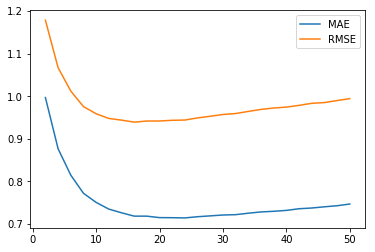

In [28]:
plt.plot(k,mae,label='MAE')
plt.plot(k,rmse,label='RMSE')
plt.legend()
plt.show()

**Q18: **<br>
best k: 18 <br/>
min mae: 0.7134 at k=22<br/>
min rmse:0.9388 at k=18<br/>


In [29]:
def popular_set(testset,popular_mID):
    index_list=[]
    trimmed_set=[]
    for i in range(0,len(testset)):
        if testset[i][1] in popular_mID:
            trimmed_set.append(testset[i])
    return trimmed_set

def unpopular_set(testset,unpopular_mID):
    index_list=[]
    trimmed_set=[]
    for i in range(0,len(testset)):
        if testset[i][1] in unpopular_mID:
            trimmed_set.append(testset[i])
    return trimmed_set

def trimmed_set(testset,idx):
    index_list=[]
    trimmed_set=[]
    for i in range(0,len(testset)):
        if testset[i][1] in idx:
            trimmed_set.append(testset[i])
    return trimmed_set

In [30]:
# Q19:
mdf=ratings_df.groupby('movieId',as_index=False,group_keys=False).count()
popular_mdf=mdf[mdf.userId>2]
popular_mID=popular_mdf['movieId'].values

rmse2=[]
k2=np.arange(2,52,2)
for j in range(2,52,2):
    print ('n_factors: '+str(j))
    kf = KFold(n_splits=10)
    nnmf=NMF(n_factors=j)
    mae=np.zeros(10)
    rmse=np.zeros(10)
    i=0
    for trainset, testset in kf.split(data):
        nnmf.fit(trainset)
        trimmed_testset=popular_set(testset,popular_mID)
        predictions = nnmf.test(trimmed_testset)
        rmse[i]=accuracy.rmse(predictions, verbose=False)
        i=i+1
    print (rmse.mean())
    rmse2.append(rmse.mean())

n_factors: 2
1.17482729824
n_factors: 4
1.05490070486
n_factors: 6
0.994206094993
n_factors: 8
0.958607792321
n_factors: 10
0.939850906442
n_factors: 12
0.9273099918
n_factors: 14
0.922818486618
n_factors: 16
0.91997835589
n_factors: 18
0.918610092695
n_factors: 20
0.920247432933
n_factors: 22
0.922669416336
n_factors: 24
0.924614674916
n_factors: 26
0.929336558642
n_factors: 28
0.932491528911
n_factors: 30
0.938544701168
n_factors: 32
0.94268067466
n_factors: 34
0.945157385302
n_factors: 36
0.949287651695
n_factors: 38
0.952887265844
n_factors: 40
0.95873580899
n_factors: 42
0.963618594977
n_factors: 44
0.966973879633
n_factors: 46
0.970436734697
n_factors: 48
0.973731997116
n_factors: 50
0.977933212238


The minimum average RMSE = 0.918610092695


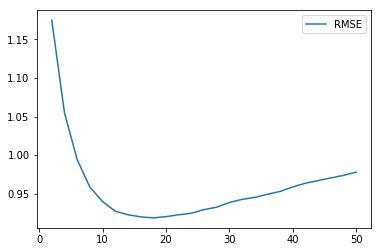

In [31]:
print('The minimum average RMSE = ' + str(np.amin(rmse2)))
plt.plot(k,rmse2,label='RMSE')
plt.legend()
plt.show()
###best K: 16
##rmse:0.9175

In [32]:
# Q20:
unpopular_mdf=mdf[mdf.userId<=2]
unpopular_mID=unpopular_mdf['movieId'].values

rmse3=[]
k2=np.arange(2,52,2)
for j in range(2,52,2):
    print ('n_factors: '+str(j))
    kf = KFold(n_splits=10)
    nnmf=NMF(n_factors=j)
    mae=np.zeros(10)
    rmse=np.zeros(10)
    i=0
    for trainset, testset in kf.split(data):
        nnmf.fit(trainset)
        trimmed_testset=unpopular_set(testset,unpopular_mID)
        predictions = nnmf.test(trimmed_testset)
        rmse[i]=accuracy.rmse(predictions, verbose=False)
        i=i+1
    print (rmse.mean())
    rmse3.append(rmse.mean())
    

n_factors: 2
1.28246382472
n_factors: 4
1.27116139095
n_factors: 6
1.27247332312
n_factors: 8
1.26390711904
n_factors: 10
1.25898071622
n_factors: 12
1.26628596161
n_factors: 14
1.24900383368
n_factors: 16
1.24846403749
n_factors: 18
1.24417727493
n_factors: 20
1.24404839051
n_factors: 22
1.23884933405
n_factors: 24
1.2419439378
n_factors: 26
1.24024465123
n_factors: 28
1.23123384212
n_factors: 30
1.23754117958
n_factors: 32
1.23035815901
n_factors: 34
1.23350031271
n_factors: 36
1.2347247268
n_factors: 38
1.22996022496
n_factors: 40
1.23308356424
n_factors: 42
1.23026558427
n_factors: 44
1.23266987644
n_factors: 46
1.22872758995
n_factors: 48
1.22837508123
n_factors: 50
1.22521503033


The minimum average RMSE = 1.22521503033


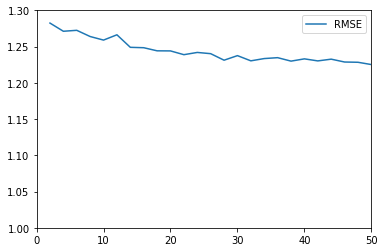

In [33]:
print('The minimum average RMSE = ' + str(np.amin(rmse3)))
plt.plot(k,rmse3,label='RMSE')
plt.axis([0,50,1.0,1.3])
plt.legend()
plt.show()
###best K: 20
##rmse:1.229

In [34]:
# Q21:
mdf1=ratings_df.groupby('movieId',as_index=False,group_keys=False).count()
mdf1=mdf1[mdf1.userId>=5]
mdf1=mdf1['movieId'].values
mdf2=ratings_df.groupby('movieId',as_index=False,group_keys=False).var()
mdf2=mdf2[mdf2.rating>2]
mdf2=mdf2['movieId'].values
mID_hvar=np.intersect1d(mdf1,mdf2)

rmse4=[]
k2=np.arange(2,52,2)
for j in range(2,52,2):
    print ('n_factors: '+str(j))
    kf = KFold(n_splits=10)
    nnmf=NMF(n_factors=j)
    mae=np.zeros(10)
    rmse=np.zeros(10)
    i=0
    for trainset, testset in kf.split(data):
        nnmf.fit(trainset)
        trimmed_testset=trimmed_set(testset,mID_hvar)
        predictions = nnmf.test(trimmed_testset)
        rmse[i]=accuracy.rmse(predictions, verbose=False)
        i=i+1
    print (rmse.mean())
    rmse4.append(rmse.mean())

n_factors: 2
1.67337036314
n_factors: 4
1.58555399723
n_factors: 6
1.61498934171
n_factors: 8
1.57759985029
n_factors: 10
1.59129300968
n_factors: 12
1.57548377351
n_factors: 14
1.56729221426
n_factors: 16
1.55886649105
n_factors: 18
1.56350163688
n_factors: 20
1.57537754535
n_factors: 22
1.57669678183
n_factors: 24
1.59289523182
n_factors: 26
1.55273726186
n_factors: 28
1.54771761316
n_factors: 30
1.57562348374
n_factors: 32
1.59145085091
n_factors: 34
1.54198537893
n_factors: 36
1.59175325969
n_factors: 38
1.57667237491
n_factors: 40
1.58033607214
n_factors: 42
1.58353487056
n_factors: 44
1.58369553884
n_factors: 46
1.58496665525
n_factors: 48
1.58885206273
n_factors: 50
1.56616329948


The minimum average RMSE = 1.54198537893


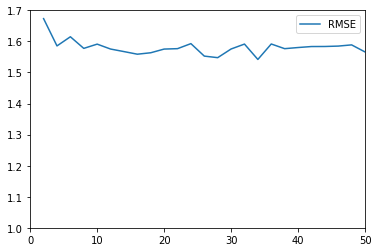

In [35]:
print('The minimum average RMSE = ' + str(np.amin(rmse4)))
plt.plot(k,rmse4,label='RMSE')
plt.axis([0,50,1.0,1.7])
plt.legend()
plt.show()
###best K: 20
##rmse:1.229

In [36]:
# Q22:
def compute_labels(real):
    thre=[2.5,3,3.5,4]
    real_= np.zeros([len(thre),len(real)])
    for n in range(0,len(thre)):
        for i in range(0,len(real)):
            if real[i]>thre[n]:
                real_[n,i]=1
            else:
                real_[n,i]=0
    return real_

In [37]:
trainset, testset = train_test_split(data, test_size=.1, random_state=42)
nnmf22=NMF(n_factors=18)
nnmf22.fit(trainset)
predictions = nnmf22.test(testset)
est_r=[]
real_r=[]
for pre in predictions:
    real_r.append(pre.r_ui)
    est_r.append(pre.est)
real_=compute_labels(real_r)

threshold: 2.5


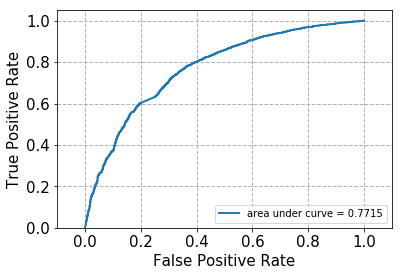

In [38]:
fpr0, tpr0,thres = roc_curve(real_[0],est_r)
print ('threshold: '+str(2.5))
plot_roc(fpr0, tpr0)
plt.show()

threshold: 3


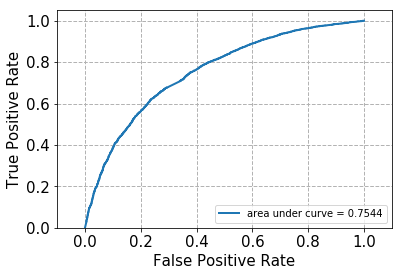

In [39]:
fpr1, tpr1,_= roc_curve(real_[1],est_r)
print ('threshold: '+str(3))
plot_roc(fpr1, tpr1)
plt.show()

threshold: 3.5


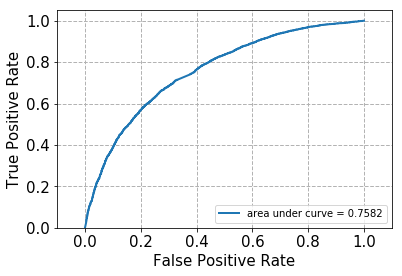

In [40]:
fpr2, tpr2,_ = roc_curve(real_[2],est_r)
print ('threshold: '+str(3.5))
plot_roc(fpr2, tpr2)
plt.show()

threshold: 4


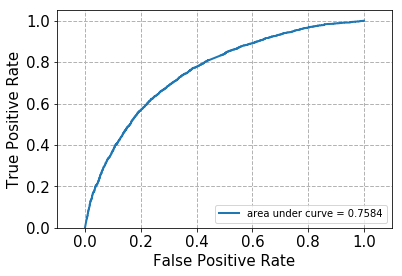

In [41]:
fpr3, tpr3,_ = roc_curve(real_[3],est_r)
print ('threshold: '+str(4))
plot_roc(fpr3, tpr3)
plt.show()

In [42]:
# Q23:
trainset23=data.build_full_trainset()
nnmf23=NMF(n_factors=20)
nnmf23.fit(trainset23)

V=nnmf23.qi
print(V)

movie_df = pd.read_csv('movies.csv')
r_df = pd.read_csv('ratings.csv')
r_df_group=r_df.groupby('movieId',as_index=False,group_keys=False).count()
combined=r_df_group.join(movie_df.set_index('movieId'),on='movieId',lsuffix='_r',rsuffix='_m')

v_sort=np.argsort(V,axis=0)[::-1]
vtop10=v_sort[:10]
print(vtop10)
print(vtop10[:,0])

vtop_df1 = pd.DataFrame(vtop10[:,18],columns=['idx'])
vjoin=vtop_df1.join(combined,on='idx',lsuffix='_v',rsuffix='_c')
print(vjoin)

user_mean=ratings_df.groupby('userId',as_index=False,group_keys=False).mean()
print(user_mean)

[[ 0.3491128   0.65974208  0.2338958  ...,  0.14805098  0.3295847
   0.52355317]
 [ 0.34382712  0.38723604  0.404033   ...,  0.45643896  0.34177287
   0.8509269 ]
 [ 0.72608507  0.24304612  0.30782444 ...,  0.20711017  0.51989117
   0.49994526]
 ..., 
 [ 0.45204579  0.15323405  0.14685643 ...,  0.43849209  0.12831119
   0.11293395]
 [ 0.0565342   0.05573804  0.05648583 ...,  0.17714123  0.08224486
   0.03609207]
 [ 0.0944297   0.10061362  0.11844413 ...,  0.08490208  0.14357893
   0.12706329]]
[[5665 2490  613 4622 5225 8468 2552 6970 4941 3559 6872 6452 5601 2535
  4882 7086 4213  203 7828 3444]
 [4463 2660 6143 1071 5533 5301 8623 3592 5291 5897 7407 6900 4852 1489
  4899  781 5905 5001 2395 7633]
 [6597 3059 4969  542 6923 5707 1246 4620 4267 2099 5273 2858 5609  601
  5542 2925  704 5557 6588 3364]
 [4594 2840 1852 1610 6777 1150 7177 5197 7633  931 2582 2057 3685 5243
  4605 1246 4684  583 5417 1217]
 [4721 2146 3827 4391 3245 2873 8616 4592 3614 3328 6215 3432 2928 7245
  1643 21

In [43]:
# Q24:
from surprise.prediction_algorithms.matrix_factorization import SVD
mae24=[]
rmse24=[]
k=np.arange(2,52,2)
for i in range(2,52,2):
    print ('n_factors: '+str(i))
    mf=SVD(n_factors=i,biased = 'true')
    cv_dict=cross_validate(mf, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)
    mae24.append(np.mean(cv_dict['test_mae']))
    rmse24.append(np.mean(cv_dict['test_rmse']))   

n_factors: 2
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8923  0.8964  0.8969  0.8962  0.8823  0.8779  0.8916  0.8763  0.8803  0.8887  0.8879  0.0076  
MAE (testset)     0.6847  0.6940  0.6885  0.6914  0.6807  0.6763  0.6816  0.6775  0.6777  0.6837  0.6836  0.0058  
Fit time          1.65    2.02    2.22    2.10    2.18    2.08    1.95    1.87    1.90    1.74    1.97    0.18    
Test time         0.13    0.11    0.07    0.11    0.09    0.08    0.06    0.09    0.06    0.06    0.09    0.02    
n_factors: 4
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9004  0.8852  0.8877  0.8730  0.8865  0.8919  0.8794  0.9011  0.8881  0.8844  0.8878  0.0081  
MAE (testset)     0.6928  0.6834  0.6806  0.6744  0.6793  0

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8885  0.8943  0.8860  0.8814  0.8887  0.8859  0.8875  0.8940  0.8975  0.8886  0.8892  0.0045  
MAE (testset)     0.6818  0.6855  0.6785  0.6800  0.6819  0.6814  0.6833  0.6877  0.6920  0.6830  0.6835  0.0037  
Fit time          4.13    4.24    4.67    4.94    5.05    5.08    4.78    4.29    4.12    3.78    4.51    0.43    
Test time         0.13    0.13    0.13    0.13    0.08    0.09    0.06    0.06    0.09    0.06    0.10    0.03    
n_factors: 30
Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8916  0.8991  0.8810  0.8838  0.8911  0.8973  0.8839  0.8806  0.8870  0.9006  0.8896  0.0071  
MAE (testset)     0.6893  0.6900  0.6804  0.6776  0.6856  0.6860  0.680

[ -7.02285279e-08   1.64204049e-05   6.83327204e-01]


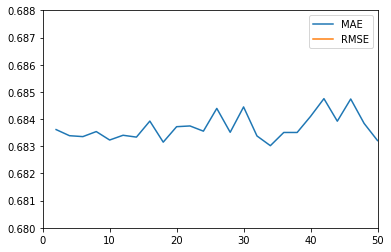

In [44]:
k=np.arange(2,52,2)
p = np.polyfit(k,mae24,deg=2)
print (p)
plt.plot(k,mae24,label='MAE')
plt.plot(k,rmse24,label='RMSE')
plt.axis([0, 50, 0.68, 0.688])
plt.legend()
plt.show()

In [45]:
# Q25:
print('The minimum average RMSE = ' + str(np.amin(rmse24)))
print('The minimum average MAE = ' + str(np.amin(mae24)))

#min value at 24

The minimum average RMSE = 0.887480926745
The minimum average MAE = 0.683021451642


In [47]:
rmse26=[]
k2=np.arange(2,52,2)
for j in range(2,52,2):
    print ('n_factors: '+str(j))
    kf = KFold(n_splits=10)
    mf=SVD(n_factors=j,biased='true')
    mae=np.zeros(10)
    rmse=np.zeros(10)
    i=0
    for trainset, testset in kf.split(data):
        mf.fit(trainset)
        trimmed_testset=popular_set(testset,popular_mID)
        predictions = mf.test(trimmed_testset)
        rmse[i]=accuracy.rmse(predictions, verbose=False)
        i=i+1
    print (rmse.mean())
    rmse26.append(rmse.mean())
    # min value at 12

n_factors: 2
0.879602827991
n_factors: 4
0.880302387129
n_factors: 6
0.880863092817
n_factors: 8
0.879766208871
n_factors: 10
0.88024500971
n_factors: 12
0.87879220515
n_factors: 14
0.879615651848
n_factors: 16
0.879570475605
n_factors: 18
0.880377470004
n_factors: 20
0.88000717279
n_factors: 22
0.880305384797
n_factors: 24
0.879892490501
n_factors: 26
0.880961607107
n_factors: 28
0.879707971715
n_factors: 30
0.880133519898
n_factors: 32
0.880542804176
n_factors: 34
0.881115011804
n_factors: 36
0.8805769827
n_factors: 38
0.880192756363
n_factors: 40
0.880576425644
n_factors: 42
0.879202216351
n_factors: 44
0.881001470899
n_factors: 46
0.879806897477
n_factors: 48
0.881251632487
n_factors: 50
0.881478100058


The minimum average RMSE = 0.87879220515


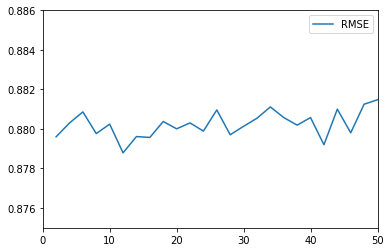

In [48]:
print('The minimum average RMSE = ' + str(np.amin(rmse26)))
plt.plot(k,rmse26,label='RMSE')
plt.axis([0,50,0.875,0.886])
plt.legend()
plt.show()

In [49]:
# Q27:
rmse27=[]
k2=np.arange(2,52,2)
for j in range(2,52,2):
    print ('n_factors: '+str(j))
    kf = KFold(n_splits=10)
    mf=SVD(n_factors=j,biased='true')
    mae=np.zeros(10)
    rmse=np.zeros(10)
    i=0
    for trainset, testset in kf.split(data):
        mf.fit(trainset)
        trimmed_testset=popular_set(testset,unpopular_mID)
        predictions = mf.test(trimmed_testset)
        rmse[i]=accuracy.rmse(predictions, verbose=False)
        i=i+1
    print (rmse.mean())
    rmse27.append(rmse.mean())

n_factors: 2
1.0092302682
n_factors: 4
1.01228270555
n_factors: 6
1.00915209453
n_factors: 8
1.01196334538
n_factors: 10
1.01145436259
n_factors: 12
1.01469683238
n_factors: 14
1.01060206865
n_factors: 16
1.01013339091
n_factors: 18
1.01342542268
n_factors: 20
1.01239181808
n_factors: 22
1.01381184516
n_factors: 24
1.01731715303
n_factors: 26
1.01533556159
n_factors: 28
1.01056405052
n_factors: 30
1.01078208092
n_factors: 32
1.01489109791
n_factors: 34
1.0134229223
n_factors: 36
1.00727231954
n_factors: 38
1.01103717222
n_factors: 40
1.01035393828
n_factors: 42
1.01854243661
n_factors: 44
1.01174774219
n_factors: 46
1.00846151589
n_factors: 48
1.01355742665
n_factors: 50
1.01722709077


The minimum average RMSE = 1.00727231954


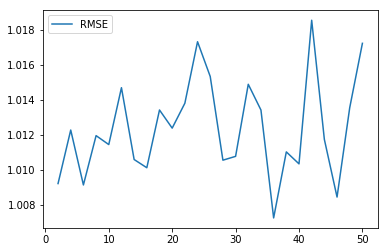

In [50]:
print('The minimum average RMSE = ' + str(np.amin(rmse27)))
plt.plot(k,rmse27,label='RMSE')
#plt.axis([0,50,1.0,1.7])
plt.legend()
plt.show()

In [51]:
# Q28: 
from surprise import accuracy
from surprise.model_selection import KFold
rmse28=[]
k2=np.arange(2,52,2)
for j in range(2,52,2):
    print ('n_factors: '+str(j))
    kf = KFold(n_splits=10)
    nnmf=SVD(n_factors=j)
    mae=np.zeros(10)
    rmse=np.zeros(10)
    i=0
    for trainset, testset in kf.split(data):
        nnmf.fit(trainset)
        trimmed_testset=trimmed_set(testset,mID_hvar)
        predictions = nnmf.test(trimmed_testset)
        rmse[i]=accuracy.rmse(predictions, verbose=False)
        i=i+1
    print (rmse.mean())
    rmse28.append(rmse.mean())

n_factors: 2
1.42242055858
n_factors: 4
1.40987948432
n_factors: 6
1.42183890471
n_factors: 8
1.42159981373
n_factors: 10
1.4280546931
n_factors: 12
1.42556372431
n_factors: 14
1.41706229018
n_factors: 16
1.42325739001
n_factors: 18
1.43178456024
n_factors: 20
1.43576619678
n_factors: 22
1.42146677939
n_factors: 24
1.41868963503
n_factors: 26
1.42903592009
n_factors: 28
1.41777699643
n_factors: 30
1.42397717278
n_factors: 32
1.42831700921
n_factors: 34
1.42492198514
n_factors: 36
1.42168330359
n_factors: 38
1.41950753239
n_factors: 40
1.43108230447
n_factors: 42
1.41754509258
n_factors: 44
1.41835599545
n_factors: 46
1.42710501002
n_factors: 48
1.43334475462
n_factors: 50
1.43808203189


The minimum average RMSE = 1.40987948432


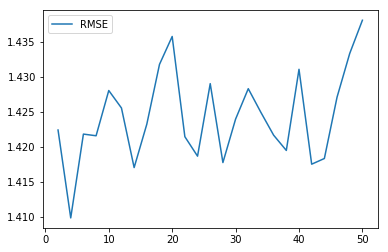

In [52]:
print('The minimum average RMSE = ' + str(np.amin(rmse28)))
plt.plot(k,rmse28,label='RMSE')
#plt.axis([0,50,1.5,1.7])
plt.legend()
plt.show()

In [53]:
# Q29:
trainset29,testset29 = train_test_split(data,test_size = 0.1, random_state=42) 
mf29=SVD(n_factors=24)
mf29.fit(trainset29)
predict = mf29.test(testset29)
est = []
real = []
for i in predict:
    est.append(i.est)
    real.append(i.r_ui)

In [54]:
thre = [2.5, 3, 3.5, 4]
real_= np.zeros([len(thre),len(est)])
for n in range(0,len(thre)):
    for i in range(0,len(real)):
        if real[i]>thre[n]:
            real_[n,i]=1
        else:
            real_[n,i]=0

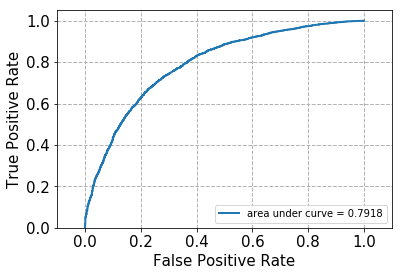

In [55]:
fpr0, tpr0,thres = roc_curve(real_[0],est)
plot_roc(fpr0, tpr0)
plt.show()

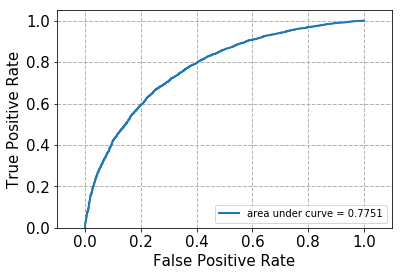

In [56]:
fpr1, tpr1,_ = roc_curve(real_[1],est)
plot_roc(fpr1, tpr1)
plt.show()

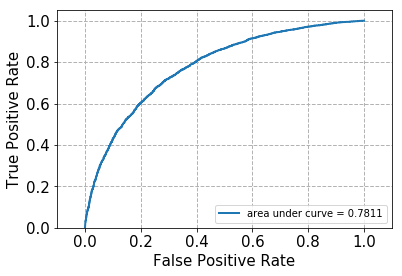

In [57]:
fpr2, tpr2,_ = roc_curve(real_[2],est)
plot_roc(fpr2, tpr2)
plt.show()

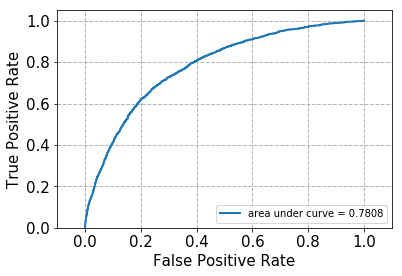

In [58]:
fpr3, tpr3,_ = roc_curve(real_[3],est)
plot_roc(fpr3, tpr3)
plt.show()

In [59]:
#Q30 Naive collaborative filtering
#rmse_mean=0.9554
from sklearn.metrics import mean_squared_error
import math
kf = KFold(n_splits=10)
rmse30=np.zeros(10)
i=0
for trainset, testset in kf.split(data):
    y_true=[]
    y_pred=[]
    for row in testset:
        y_true.append(row[2])
        p=user_mean.loc[user_mean.userId==row[0]]['rating'].values
        y_pred.append(p[0])
    mse=mean_squared_error(y_true,y_pred)
    rmse30[i]=math.sqrt(mse)
    i=i+1
print (rmse30.mean())

0.955390574152


In [60]:
#Q31 rmse_mean=0.9521
kf = KFold(n_splits=10)
rmse31=np.zeros(10)
i=0
for trainset, testset in kf.split(data):
    y_true=[]
    y_pred=[]
    trimmed_testset=trimmed_set(testset,popular_mID)
    for row in trimmed_testset:
        y_true.append(row[2])
        p=user_mean.loc[user_mean.userId==row[0]]['rating'].values
        y_pred.append(p[0])
    mse=mean_squared_error(y_true,y_pred)
    rmse31[i]=math.sqrt(mse)
    i=i+1
print (rmse31.mean())

0.952098553686


In [61]:
#Q32 rmse_mean=1.0092
kf = KFold(n_splits=10)
rmse32=np.zeros(10)
i=0
for trainset, testset in kf.split(data):
    y_true=[]
    y_pred=[]
    trimmed_testset=trimmed_set(testset,unpopular_mID)
    for row in trimmed_testset:
        y_true.append(row[2])
        p=user_mean.loc[user_mean.userId==row[0]]['rating'].values
        y_pred.append(p[0])
    mse=mean_squared_error(y_true,y_pred)
    rmse32[i]=math.sqrt(mse)
    i=i+1
print (rmse32.mean())

1.01026029798


In [62]:
#Q33 rmse_mean=1.4403
kf = KFold(n_splits=10)
rmse33=np.zeros(10)
i=0
for trainset, testset in kf.split(data):
    y_true=[]
    y_pred=[]
    trimmed_testset=trimmed_set(testset,mID_hvar)
    for row in trimmed_testset:
        y_true.append(row[2])
        p=user_mean.loc[user_mean.userId==row[0]]['rating'].values
        y_pred.append(p[0])
    mse=mean_squared_error(y_true,y_pred)
    rmse33[i]=math.sqrt(mse)
    i=i+1
print (rmse33.mean())

1.42992968982


Computing the pearson similarity matrix...
Done computing similarity matrix.


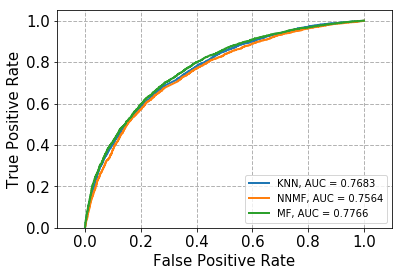

In [63]:
# Q34:
fig, ax = plt.subplots()
ax.grid(color='0.7', linestyle='--', linewidth=1)
ax.set_xlim([-0.1, 1.1])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate',fontsize=15)

for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontsize(15)

#<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

knn = KNNWithMeans(k = 18,sim_options = {'name': 'pearson'})
knn.fit(data_train)
predictions = knn.test(data_test)
predR = []
realR = []
for pred in predictions:
    predR.append(pred.est)
    realR.append(pred.r_ui)

thres = 3
predR_binary = []
realR_binary = []
for i in range(len(predR)):
    realR_binary.append(realR[i]>thres)
    
fpr, tpr, thresholds = roc_curve(realR_binary, predR)
roc_auc = auc(fpr,tpr)
ax.plot(fpr, tpr, lw=2, label= 'KNN, AUC = %0.4f' % roc_auc)

#<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
trainset, testset = train_test_split(data, test_size=.1, random_state=42)
nnmf22=NMF(n_factors=18)
nnmf22.fit(trainset)
predictions = nnmf22.test(testset)
predR = []
realR = []
for pred in predictions:
    predR.append(pred.est)
    realR.append(pred.r_ui)

predR_binary = []
realR_binary = []
for i in range(len(predR)):
    realR_binary.append(realR[i]>thres)
fpr, tpr, thresholds = roc_curve(realR_binary, predR)
roc_auc = auc(fpr,tpr)
ax.plot(fpr, tpr, lw=2, label= 'NNMF, AUC = %0.4f' % roc_auc)

#<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
trainset29,testset29 = train_test_split(data,test_size = 0.1, random_state=42) 
mf29=SVD(n_factors=24)
mf29.fit(trainset29)
predictions = mf29.test(testset29)
predR = []
realR = []
for pred in predictions:
    predR.append(pred.est)
    realR.append(pred.r_ui)

predR_binary = []
realR_binary = []
for i in range(len(predR)):
    realR_binary.append(realR[i]>thres)
fpr, tpr, thresholds = roc_curve(realR_binary, predR)
roc_auc = auc(fpr,tpr)
ax.plot(fpr, tpr, lw=2, label= 'MF, AUC = %0.4f' % roc_auc)

#<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
ax.legend(loc="lower right")
plt.show()

** Q35: **
Precision is the ratio of the number of movies that the recommendation system has correctly predicted to the total number of movies that the recommendation system predicts (mix of correct and wrong predictions). In other words, it is how precise of the prediction.
Recall is the ratio of the number of movies that the recommendation system has correctly predicted to the number of movies that a user actually likes. 


In [64]:
# Q36:
kf = KFold(n_splits=10)
knn = KNNWithMeans(k = 18,sim_options = {'name': 'pearson'})

APre = np.zeros((25,1))
ARec = np.zeros((25,1))
    
for t in np.arange(1,26):
    Pre = 0
    Rec = 0
    
    for trainset, testset in kf.split(data): #KFold
        knn.fit(trainset)
        predictions = knn.test(testset)

        uid = []
        iid = []
        r_ui = []
        est = []
        for pred in predictions: #Get Prediction
            uid.append(pred.uid)
            iid.append(pred.iid)
            r_ui.append(pred.r_ui)
            est.append(pred.est)
    
        precision = 0
        recall = 0
        ucnt = 0
        uniUid = np.unique(uid)
        
        for idx in np.arange(len(uniUid)):
            #print('user',idx+1)
            mList = []
            rList = []
            eList = []
            SmList = []
    
            for u in range(len(uid)):
                if uid[u] == uniUid[idx]:
                    mList.append(iid[u])
                    rList.append(r_ui[u]) 
                    eList.append(est[u])
            #print(rList)
            GT = np.array(rList) > 3
            #print(GT)
            #print(np.count_nonzero(GT == 1)== 0)
            if len(rList) < t or np.count_nonzero(GT == 1)== 0: 
               # print('remove this user')
                continue
    
            sortidx = np.argsort(eList)[::-1]
            for i in sortidx: SmList.append(mList[i])
            recom = SmList[0:t]
   
            like = []
            for j in np.arange(len(mList)):
                if GT[j] == 1: like.append(mList[j])
            
            # precision and recall for each user    
            precision += np.count_nonzero(np.isin(recom,like)) / len(recom)
            recall += np.count_nonzero(np.isin(recom,like)) / len(GT == 1)
            ucnt += 1
        
        # precision and recall for each fold
        Pre += precision/ucnt
        Rec += recall/ucnt

    APre[t-1,0] = Pre/10
    ARec[t-1,0] = Rec/10
print(APre)
print(ARec)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

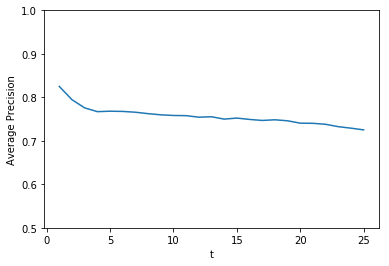

In [65]:
# Average precision against t
t = np.arange(1,26)
plt.xlabel('t')
plt.ylabel('Average Precision')
plt.ylim([0.5, 1])
plt.plot(t, APre)
plt.show()

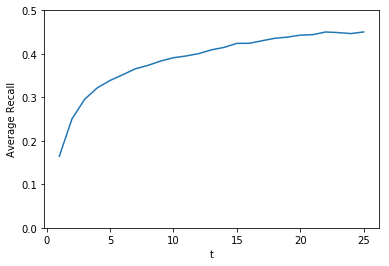

In [66]:
# Average recall against t
plt.xlabel('t')
plt.ylabel('Average Recall')
plt.ylim([0, 0.5])
plt.plot(t, ARec)
plt.show()

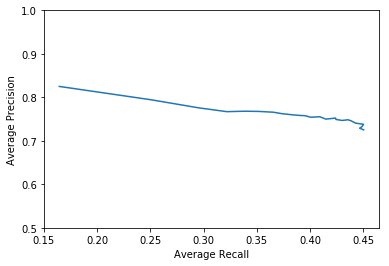

In [67]:
# Average precision against average recall
plt.ylabel('Average Precision')
plt.ylim([0.5, 1])
plt.xlabel('Average Recall')
plt.plot(ARec, APre)
plt.show()

In [68]:
#Q37
#The function used to return the value of |S|,|G|,|S&G| in each fold
def rank(predict,t):
    id_sort=[]
    all_g=[]
    all_g_=[]
    unique_id=[]
    pending = []
    count_id =0
    pre_id=[-1,0]
    dele_id =[]
    
    filt_id=[]
    
    us_id =[]
    
    each_user = []
  
    G_count = 0
    S_count = 0
    SG_count = 0
    
    user=sorted(predict, key=lambda user: user[0])
    max_l = len(user)
    max_id=user[max_l-1][0]
    # Ground Truth: if user have |G|=0, drop the user
    for n in range(0,max_l):
        if(user[n][2]>3) :
            all_g.append(user[n])
    for x in range(0,len(all_g)):
        if(all_g[x][0] in unique_id ):
            continue
        else:
            unique_id.append(all_g[x][0])
    for m in range(0,max_l):
        if(user[m][0] in unique_id): 
            all_g_.append(user[m])
            
   
    # Enough rating: if the user rate the number of movie<t, drop the user
    for p in range(len(all_g_)):
        if (all_g_[p][0]!=pre_id[0]):
            if pre_id[1]<t:
                dele_id.append(pre_id[0])
            pre_id[1]=0
            pre_id[0]=all_g_[p][0]
        else:
            pre_id[1]=pre_id[1]+1
    for a in range(len(all_g_)):
        if all_g_[a][0] in dele_id:
            continue
        else:
            filt_id.append(all_g_[a])
    
    # Filtered User Id
    for b in range(0,len(filt_id)):
        if(filt_id[b][0] in us_id ):
            continue
        else:
            us_id.append(filt_id[b][0])
            
            
    # Unique id list: get the user_id list of non |G|=0 and |rating|>t, with according index
    for o in range(len(us_id)):
        pending.append([o,us_id[o]])
        
    #Change Matrix of filt_id to Dataframe
    df = pd.DataFrame(np.reshape(filt_id,[len(filt_id),5]), columns = list("IMREN"))
    
    #Sort ratings by user id
    df_sort=df.sort_values(['I','E'],ascending=False).groupby('I').head(t)
    df_ = df_sort.values
    
    #Calculate precision and recall
    df_total = df.sort_values(['I','E'],ascending=False)
    df_t = df_total.values
    for dt in range(len(df_t)):
        if df_t[dt][2] > 3:
            G_count+=1
    for ds in range(len(df_)):
        if df_[ds][2] > 3 :
            SG_count+=1
    S_count = t*len(us_id)
    
    
    return G_count,SG_count,S_count

In [69]:
kf = KFold(n_splits=10)
nnmf=NMF(n_factors=18)
i=0
G_count37=np.zeros(25)
S_count37=np.zeros(25)
SG_count37=np.zeros(25)
precision37=np.zeros([10,25])
recall37 = np.zeros([10,25])
for trainset, testset in kf.split(data):
    nnmf.fit(trainset)
    predict[i]= nnmf.test(testset)
    for t in range(1,26):
        G_count37[t-1],SG_count37[t-1],S_count37[t-1]=rank(predict[i],t)
    precision37[i] = np.divide(SG_count37,S_count37)
    recall37[i] = np.divide(SG_count37,G_count37)
    i=i+1
precision37 = np.mean(precision37,axis=0)
recall37 = np.mean(recall37,axis=0)

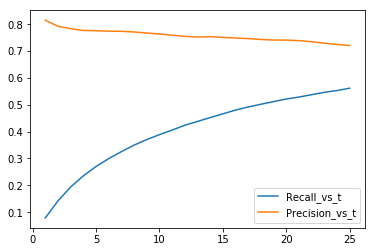

In [70]:
t = range(1,26)
plt.plot(t,recall37,label='Recall_vs_t')
plt.plot(t,precision37,label='Precision_vs_t')
plt.legend()
plt.show()

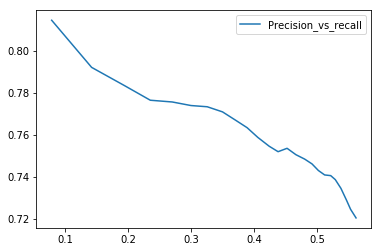

In [71]:
plt.plot(recall37,precision37,label='Precision_vs_recall')
plt.legend()
plt.show()

In [72]:
# Q38:
kf = KFold(n_splits=10)
mf=SVD(n_factors=24,biased='true')
i=0
G_count38=np.zeros(25)
S_count38=np.zeros(25)
SG_count38=np.zeros(25)
precision38=np.zeros([10,25])
recall38 = np.zeros([10,25])
for trainset, testset in kf.split(data):
    mf.fit(trainset)
    predict[i]= mf.test(testset)
    for t in range(1,26):
        G_count38[t-1],SG_count38[t-1],S_count38[t-1]=rank(predict[i],t)
    precision38[i] = np.divide(SG_count38,S_count38)
    recall38[i] = np.divide(SG_count38,G_count38)
    i=i+1
precision38 = np.mean(precision38,axis=0)
recall38 = np.mean(recall38,axis=0)

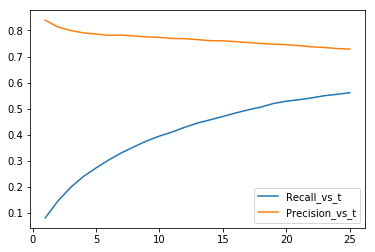

In [73]:
t = range(1,26)
plt.plot(t,recall38,label='Recall_vs_t')
plt.plot(t,precision38,label='Precision_vs_t')
plt.legend()
plt.show()

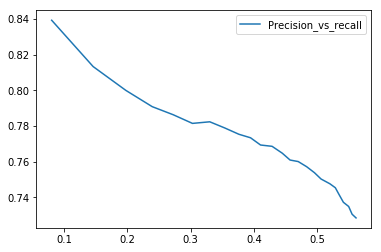

In [74]:
plt.plot(recall38,precision38,label='Precision_vs_recall')
plt.legend()
plt.show()

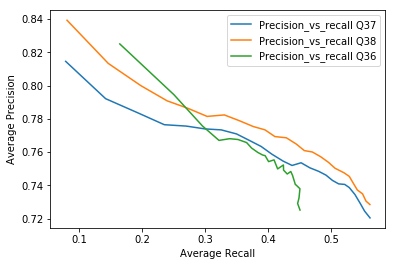

In [75]:
# Q39:
plt.plot(recall37,precision37,label='Precision_vs_recall Q37')
plt.plot(recall38,precision38,label='Precision_vs_recall Q38')
plt.plot(ARec, APre,label='Precision_vs_recall Q36')
plt.ylabel('Average Precision')
plt.xlabel('Average Recall')
plt.legend()
plt.show()